# Contents of this Notebook
• Quick look at some images in the dataset

• Download a few categories of shape positives and some categories to distinguish those from

• Download the classification text file

• Set some core variables needed throughout

• Load flattened arrays (N, 784) → reshape to (N, 28, 28)

• Organise data into X and y

• Define and compile the model

• Test train split

• Training

• Preview, graphs, refinement

• Saving the model and converting it into a javascript model (tensorflowjs) via terminal commands



In [33]:
from IPython.display import display
from quickdraw import QuickDrawDataGroup
import os, urllib.request
import requests
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import json, pathlib
from google.cloud import storage
from dotenv import load_dotenv, dotenv_values
from scipy.ndimage import rotate
import tensorflow as tf
from math import sin, cos, radians

In [2]:
# Load your .env file
load_dotenv()

# Resolve full path to service account JSON
key_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
if not key_path:
    raise ValueError("GOOGLE_APPLICATION_CREDENTIALS not set in .env")

key_path = os.path.abspath(os.path.expanduser(key_path))
config = dotenv_values(".env").get('GOOGLE_APPLICATION_CREDENTIALS')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config

In [ ]:
circle_group = QuickDrawDataGroup("circle", max_drawings=10000)

for _ in range(5):
    d = circle_group.get_drawing()
    display(d.image)

In [34]:
DATA_DIR = "data"  # where your .npy files are

TARGETS = ["circle", "square", "triangle", "star", "vertical_arrows", "axis"]
OTHERS  = ["face", "cat", "cloud", "house", "tree"]

CLASS_NAMES = TARGETS + ["other"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}

classes = TARGETS + OTHERS

In [35]:
# Assumes you've already authenticated using your .env and service account key
# and set GOOGLE_APPLICATION_CREDENTIALS properly before this code runs

bucket_name = "doodle-autocomplete"
prefix = "training-data"

# Make the data directory if you don't have it
os.makedirs(DATA_DIR, exist_ok=True)

# Create GCS client
client = storage.Client()
bucket = client.bucket(bucket_name)

for c in classes:
    blob_path = f"{prefix}/{c}.npy"
    dst = os.path.join(DATA_DIR, f"{c}.npy")

    if not os.path.exists(dst):
        print(f"Downloading {blob_path} from GCS...")
        blob = bucket.blob(blob_path)
        blob.download_to_filename(dst)

print("Done ✅")

Done ✅


In [ ]:
# Pull from official QuickDraw data

os.makedirs(DATA_DIR, exist_ok=True) #make the data directory if you don't have it on your machine

base = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap"

for c in classes:
    url = f"{base}/{c}.npy"
    dst = os.path.join(DATA_DIR, f"{c}.npy")
    if not os.path.exists(dst):
        print("downloading", url)
        urllib.request.urlretrieve(url, dst)
print("done")

# 1. About the data - What Google did with QuickDraw

Each QuickDraw doodle was drawn by a person as a sequence of strokes (vector data).

Google rasterised those strokes into 28 × 28 pixel images, grayscale.

Each pixel is **grayscale** — it holds an intensity value from 0 to 255 (0 = black, 255 = white, or sometimes inverted depending on convention).

To make the dataset compact, they then flattened each 28×28 image into a 1D vector of length 784 (because 28 × 28 = 784).

In [36]:
def load_npy(path, limit=None):
    """
    Quick, Draw! numpy_bitmap .npy: shape (N, 784) uint8.
    Returns (N, 28, 28) uint8.
    """
    arr = np.load(path)                 # (N, 784) uint8
    if limit is not None:
        arr = arr[:limit]
    return arr.reshape(-1, 28, 28)      # -> (N,28,28)

# Logic of the data distribution in the model
Some false positive classes were included to train the model - it needs to learn not only to recognise circles and squares but also to disregard random stuff. The random stuff included in this model is:

 "face", "cat", "cloud", "house", "tree"

 But this could be increased to make a better model.

 Below the function therefore deals with both of those.


# What the function returns

X: all images, normalised to [0,1] and shaped (N, 28, 28, 1) (float32).

y: one integer label per image, shaped (N,) (int64). Uses your CLASS_TO_ID mapping.

In [ ]:
# def build_arrays(data_dir, per_class=10000, other_total=5000, seed=0):
#     rng = np.random.default_rng(seed)  # for a reproducible final shuffle

#     Xs, ys = [], []  # we collect per-class arrays here (features X, labels y)

#     # 1) TARGET classes: circle/square/triangle/star
#     for cname in TARGETS:
#         Xc = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_class)
#         # Xc: (per_class, 28, 28) uint8 — the images for this target class
#         yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
#         # yc: (per_class,) int64 — the labels for this class, all the same id
#         Xs.append(Xc)
#         ys.append(yc)

#     # 2) "OTHER" bucket: pool several categories into one label
#     per_other = max(1, other_total // len(OTHERS))  # try to sample evenly
#     other_parts = []
#     for cname in OTHERS:
#         Xo_part = load_npy(os.path.join(data_dir, f"{cname}.npy"), per_other)
#         other_parts.append(Xo_part)
#     Xo = np.concatenate(other_parts, axis=0)             # (~other_total, 28, 28)
#     yo = np.full(len(Xo), CLASS_TO_ID["other"], dtype=np.int64)  # same id for all

#     # 3) Concatenate everything into single feature/label arrays
#     X = np.concatenate(Xs + [Xo], axis=0)  # (N, 28, 28) uint8
#     y = np.concatenate(ys + [yo], axis=0)  # (N,)        int64

#     # 4) Normalise & add channel dim for Keras (channels-last)
#     X = (X.astype("float32") / 255.0)[..., None]  # (N, 28, 28, 1) float32

#     # 5) Final shuffle to mix classes so batches aren’t blocky
#     idx = rng.permutation(len(X))
#     return X[idx], y[idx]


In [ ]:
def build_arrays(data_dir, per_class=10000, other_total=5000, seed=0):
    rng = np.random.default_rng(seed)

    Xs = []
    ys_class = []
    ys_orient = []

    for cname in TARGETS:
        path = os.path.join(data_dir, f"{cname}.npy")

        if cname == "vertical_arrows":
            max_samples = 500      # number of vertical arrows to sample
            rotations_per_img = 24 # rotate each selected image 24 ways

            X_base = load_npy(path)  # load all vertical arrow images

            # Subsample vertical arrows randomly
            if len(X_base) > max_samples:
                X_base = rng.choice(X_base, size=max_samples, replace=False)

            Xc, yo = [], []
            for img in X_base:
                angles = np.linspace(0, 360, rotations_per_img, endpoint=False)
                for angle in angles:
                    rotated_img = rotate(img, angle, reshape=False, order=1, mode='constant', cval=0.0)
                    Xc.append(rotated_img)
                    yo.append(angle)

            Xc = np.array(Xc)
            yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
            yo = np.array(yo).astype(np.float32)

            yo_sin_cos = np.zeros((len(yo), 2), dtype=np.float32)
            yo_rad = np.deg2rad(yo)          # convert degrees to radians
            yo_sin_cos[:, 0] = np.sin(yo_rad)
            yo_sin_cos[:, 1] = np.cos(yo_rad)
            yo = yo_sin_cos                  # replace yo with sin/cos

        else:
            Xc = load_npy(path, limit=per_class)
            yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
            yo = np.full((len(Xc), 2), -999.0, dtype=np.float32) #setting masking values for sin and cos angle of "other" class

        Xs.append(Xc)
        ys_class.append(yc)
        ys_orient.append(yo)

    # Process OTHER classes as before
    per_other = max(1, other_total // len(OTHERS))
    other_parts = []
    for cname in OTHERS:
        path = os.path.join(data_dir, f"{cname}.npy")
        Xo_part = load_npy(path, limit=per_other)
        other_parts.append(Xo_part)

    Xo = np.concatenate(other_parts, axis=0)
    yo = np.full((len(Xo), 2), -999.0, dtype=np.float32)
    yc = np.full(len(Xo), CLASS_TO_ID["other"], dtype=np.int64)

    Xs.append(Xo)
    ys_class.append(yc)
    ys_orient.append(yo)

    # Concatenate all data
    X = np.concatenate(Xs, axis=0)
    y_class = np.concatenate(ys_class, axis=0)
    y_orient = np.concatenate(ys_orient, axis=0)

    # Normalize and add channel dim
    X = (X.astype("float32") / 255.0)[..., None]

    # Shuffle
    idx = rng.permutation(len(X))
    return X[idx], y_class[idx], y_orient[idx]

In [40]:
X, y_class, y_orient = build_arrays(DATA_DIR, per_class=5000, other_total=5000)  # ~15k total
X.shape, y_class.shape, y_orient.shape, np.bincount(y_class)
# Expect: ((~15000, 28, 28, 1), (~15000,), counts per class)

((37511, 28, 28, 1),
 (37511,),
 (37511, 2),
 array([ 5000,  5000,  5000,  5000, 12000,   511,  5000]))

In [10]:
#This function is to create augmented data for more variety in the training samples during model fitting.
rotation_layer = tf.keras.layers.RandomRotation(
    factor=0.15,  # ±15% of a full rotation
    fill_mode='constant'
)

def augment_fn(img, y_class, y_orient):
    if tf.equal(y_class, CLASS_TO_ID["vertical_arrows"]):
        # no augmentation for vertical-line
        return img, (y_class, y_orient)
    else:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        # apply RandomRotation layer
        img = rotation_layer(tf.expand_dims(img, axis=0))  # add batch dim
        img = tf.squeeze(img, axis=0)                     # remove batch dim
        return img, (y_class, y_orient)

In [97]:
n_classes = len(CLASS_NAMES)

# Input layer
inputs = layers.Input(shape=(28,28,1))

# Shared CNN
x = layers.Conv2D(16,3,padding="same",activation="relu")(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32,3,padding="same",activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
shared_dense = layers.Dense(64, activation="relu")(x)

# Classification branch
class_output = layers.Dense(n_classes, activation="softmax", name="class_output")(shared_dense)

# Orientation branch
orient_branch = layers.Dense(32, activation="relu")(shared_dense)
orient_output = layers.Dense(2, activation="linear", name="orient_output")(orient_branch)

# Create the model with two outputs
model = models.Model(inputs=inputs, outputs=[class_output, orient_output], name="classifier")


# custom loss function that looks at the difference in angles
def angle_loss(y_true, y_pred):
    # mask invalid targets
    mask = tf.reduce_sum(tf.abs(y_true + 999), axis=1) > 0
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    # if no valid angles, return 0
    def valid_loss():
        # normalize predictions to unit length
        y_pred_norm = tf.nn.l2_normalize(y_pred_masked, axis=1)
        cos_diff = tf.reduce_sum(y_true_masked * y_pred_norm, axis=1)
        return tf.reduce_mean(1 - cos_diff)

    return tf.cond(tf.size(y_true_masked) > 0, valid_loss, lambda: 0.0)


model.compile(optimizer="adam",
              loss={
                  "class_output": "sparse_categorical_crossentropy",
                  "orient_output": angle_loss
              },
              loss_weights={
                  "class_output": 1.0,
                  "orient_output": 0.5,
              },
              metrics={
                  "class_output": "accuracy",
                  "orient_output": "mae"
              })

model.summary()

Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 28, 28, 16)           160       ['input_19[0][0]']            
                                                                                                  
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 16)           0         ['conv2d_36[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 14, 14, 32)           4640      ['max_pooling2d_36[0]

In [ ]:
# n_classes = len(CLASS_NAMES)

# model = Sequential([
#     layers.Input(shape=(28,28,1)),
#     layers.Conv2D(16, 3, padding="same", activation="relu"),
#     layers.MaxPooling2D(2),                # 28→14
#     layers.Conv2D(32, 3, padding="same", activation="relu"),
#     layers.MaxPooling2D(2),                # 14→7
#     layers.Flatten(),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(n_classes, activation="softmax"),
# ])

# # 2) augmentation pipeline
# data_augmentation = models.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.15, fill_mode="constant", fill_value=0.0),
# ], name="aug")

# # 3) training model = aug + model
# train_model = models.Sequential([
#     layers.Input(shape=(28,28,1)),
#     data_augmentation,
#     model
# ], name="train_model")

# model.compile(optimizer="Adam",
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])
# model.summary()


In [ ]:
# Split the data and both labels; stratify on class labels
Xtr, Xva, y_class_tr, y_class_va, y_orient_tr, y_orient_va = train_test_split(
    X, y_class, y_orient, test_size=0.1, random_state=39, stratify=y_class
)

# Create tf.data.Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((Xtr, (y_class_tr, y_orient_tr)))
val_ds   = tf.data.Dataset.from_tensor_slices((Xva, (y_class_va, y_orient_va)))

# # Apply conditional augmentation only to training dataset
# train_ds = train_ds.map(
#     lambda x, y: augment_fn(x, y[0], y[1]),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

# Shuffle, batch, and prefetch
train_ds = train_ds.shuffle(2048).batch(128).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(128).prefetch(tf.data.AUTOTUNE)

es = EarlyStopping(patience=30, restore_best_weights=True)


# --- Training ---
model.fit(
    X,
    {"class_output": y_class, "orient_output": y_orient},
    batch_size=64,
    epochs=60,
)

Epoch 1/60


ValueError: in user code:

    File "/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/mayaamaryllis/.pyenv/versions/3.11.1/envs/doodle-autocomplete/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'max_pooling2d_36' (type MaxPooling2D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node classifier/max_pooling2d_36/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](classifier/conv2d_36/Relu)' with input shapes: [28,28,1,16].
    
    Call arguments received by layer 'max_pooling2d_36' (type MaxPooling2D):
      • inputs=tf.Tensor(shape=(28, 28, 1, 16), dtype=float32)


In [ ]:
def show_grid(X, y, n=10):
    plt.figure(figsize=(12,2))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(X[i,...,0], cmap="gray")
        plt.title(CLASS_NAMES[y[i]], fontsize=9)
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_grid(Xtr, ytr, n=12)


In [ ]:
# predictions on validation set
proba = model.predict(Xva, verbose=0)
yhat  = proba.argmax(axis=1)

print(classification_report(yva, yhat, target_names=CLASS_NAMES, digits=3))

# confusion matrix (vanilla matplotlib)
cm = confusion_matrix(yva, yhat, labels=range(len(CLASS_NAMES)))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(CLASS_NAMES))); ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()


In [ ]:
def predict_with_reject(Xb, tau=0.6):
    proba = model.predict(Xb, verbose=0)
    maxp  = proba.max(axis=1)
    arg   = proba.argmax(axis=1)
    labels = np.where(maxp < tau, -1, arg)  # -1 = unknown
    return labels, maxp, proba

# sweep τ to see trade-off
taus = np.linspace(0.4, 0.9, 11)
accs = []
for t in taus:
    labels, _, _ = predict_with_reject(Xva, tau=t)
    # treat unknown as wrong for this simple score
    ok = (labels == yva)
    accs.append(ok.mean())

plt.figure(); plt.plot(taus, accs, marker="o")
plt.xlabel("tau (rejection threshold)"); plt.ylabel("val accuracy (unknown counted as wrong)")
plt.title("Pick a τ you like"); plt.show()


In [ ]:
# pick a few that weren't in TARGETS or OTHERS
UNSEEN = ["airplane","banana","bus","chair"]
unseen_batch = []
for c in UNSEEN:
    path = os.path.join(DATA_DIR, f"{c}.npy")
    if os.path.exists(path):
        arr = np.load(path)[:200].reshape(-1,28,28,1).astype("float32")/255.0
        unseen_batch.append(arr)
if unseen_batch:
    X_unseen = np.concatenate(unseen_batch, axis=0)
    labels, maxp, _ = predict_with_reject(X_unseen, tau=0.6)
    unknown_rate = (labels==-1).mean()
    print(f"Unknown rate on unseen classes: {unknown_rate:.2%} (want this fairly high)")

In [ ]:

def predict_one_live(img28, tau=0.6, mdl=model, classes=CLASS_NAMES):
    x = img28.astype("float32")
    if x.max() > 1.0:
        x = x / 255.0
    x = x[None, ..., None]
    proba = mdl.predict(x, verbose=0)[0]
    i = proba.argmax()
    return ("unknown", float(proba[i])) if proba[i] < tau else (classes[i], float(proba[i]))


# demo on a val sample
lbl, conf = predict_one_live((Xva[0,...,0]*255).astype("uint8"), tau=0.6)
lbl, conf, "true:", CLASS_NAMES[yva[0]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_and_show(img_flat, model, class_names=CLASS_NAMES):
    """
    Predicts the class and orientation of a Quick, Draw! sample
    and displays the image.

    Parameters:
        img_flat: np.ndarray, shape (784,) — flattened image
        model: trained Keras model with two outputs
        class_names: list of class names, matching model output
    """
    # Prepare image
    img = img_flat.reshape(28,28).astype("float32") / 255.0  # normalize
    img = np.expand_dims(img, axis=-1)  # add channel dim (28,28,1)
    img = np.expand_dims(img, axis=0)   # add batch dim (1,28,28,1)

    # Predict
    class_pred, orient_pred = model.predict(img, verbose=0)
    pred_class_idx = np.argmax(class_pred, axis=1)[0]
    pred_class_name = class_names[pred_class_idx]
    pred_orientation = orient_pred[0][0]

    angle_pred_rad = np.arctan2(orient_pred[0][0], orient_pred[0][1])
    angle_pred_deg = np.degrees(angle_pred_rad) % 360

    # Show image
    plt.imshow(img[0,...,0], cmap='gray')
    plt.title(f"Predicted: {pred_class_name}\nOrientation: {angle_pred_deg:.1f}")
    plt.axis('off')
    plt.show()

    return pred_class_name, angle_pred_deg

In [ ]:
# jitter the training images by ±1 pixel
def jitter_shift(x):
    dy = np.random.randint(-1, 2)
    dx = np.random.randint(-1, 2)
    return np.roll(np.roll(x, dy, axis=0), dx, axis=1)

aug_X = Xtr.copy()
mask = np.random.rand(len(aug_X)) < 0.5
aug_X[mask,...,0] = np.array([jitter_shift(im) for im in aug_X[mask,...,0]])

#history = model.fit(aug_X, ytr, validation_data=(Xva, yva), epochs=6, batch_size=32, callbacks=[es], verbose=1)


In [61]:
import matplotlib.pyplot as plt

def predict_and_show_rotated(img_rotated, model, class_names=CLASS_NAMES):
    """
    Predict class and orientation of a rotated Quick, Draw! image and display it with an arrow.

    Parameters:
        img_rotated: np.ndarray, shape (28,28) — already rotated image
        model: trained Keras model with two outputs
        class_names: list of class names

    Returns:
        pred_class_name: str
        pred_orientation: float (degrees)
    """
    # Normalize and add channel/batch dimensions
    img_input = img_rotated.astype("float32") / 255.0  # normalize
    img_input = img_input[..., None]                  # (28,28,1)
    img_input = np.expand_dims(img_input, axis=0)     # (1,28,28,1)

    # Predict
    class_pred, orient_pred = model.predict(img_input, verbose=0)
    pred_class_idx = np.argmax(class_pred, axis=1)[0]
    pred_class_name = class_names[pred_class_idx]
    pred_orientation = orient_pred[0][0]

    # Display
    plt.imshow(img_rotated, cmap='gray')
    plt.axis('off')
    plt.title(f"{pred_class_name}\nPredicted orientation: {pred_orientation:.1f}°")

    # Draw arrow
    center = (14,14)
    length = 10
    angle_rad = np.deg2rad(pred_orientation)
    dx = length * np.cos(angle_rad)
    dy = -length * np.sin(angle_rad)  # negative because image y-axis is top→bottom
    plt.arrow(center[0], center[1], dx, dy, color='red', head_width=2, head_length=3)
    plt.show()

    return pred_class_name, pred_orientation

In [62]:
from scipy.ndimage import rotate

# Load vertical_arrows class
arr = np.load("data/vertical_arrows.npy")  # shape (N, 784)

# Pick the 4th sample (index 3)
img_flat = arr[10]

# Choose a random rotation angle (0–360 degrees)
angle = np.random.uniform(0, 360)

# Rotate the image
img_rotated = rotate(img_flat.reshape(28,28), angle, reshape=False, order=1, mode='constant')

### Display the rotated image

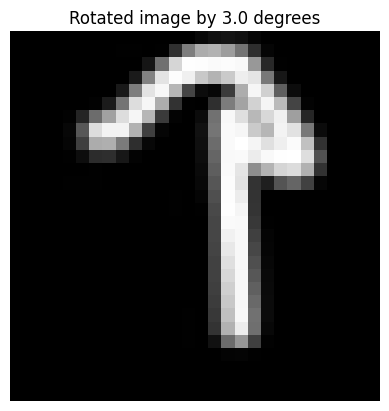

Rotation angle: 2.9878505326418603


In [63]:
plt.imshow(img_rotated, cmap='gray')
plt.title(f"Rotated image by {angle:.1f} degrees")
plt.axis('off')
plt.show()

print("Rotation angle:", angle)

[array([[0.01076689, 0.0106689 , 0.01047701, 0.00865637, 0.90680146,
        0.04228568, 0.01034373]], dtype=float32), array([[-51.576534, -51.560356]], dtype=float32)]


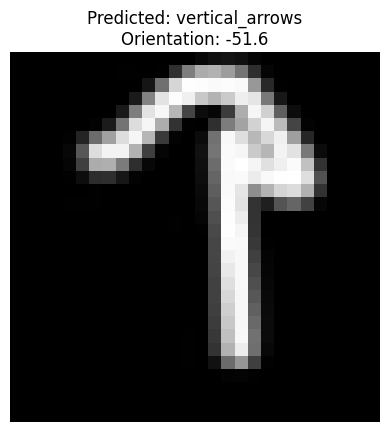

In [64]:
pred_class, pred_orient = predict_and_show(img_rotated, model)

In [ ]:
CLASS_NAMES

In [ ]:
model.save("shapes_tinycnn_keras_plus_arrows.h5")

In [ ]:
#  Now go to terminal to make a js model
!tensorflowjs_converter --input_format=keras \
    shapes_tinycnn_keras_plus_vertical_line.h5 \
    web_model/